In [ ]:
!pip install timm transformers datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## 🚀 Setup, Dataset Loading, and Vision Transformer (ViT)

### 📦 Step 1: Importing Libraries
We begin by importing all required libraries including:
- `torch` and `torchvision` for model training and datasets
- `timm` for pretrained Vision Transformer (ViT) models
- `matplotlib` for visualization
- `transformers` for potential feature extraction utilities

---

### 🌸 Step 2: Loading Flowers102 Dataset
We use the **Flowers102 dataset** from `torchvision.datasets`. It contains 102 flower categories and is split into train and test sets.

We apply standard preprocessing:
- Resize images to 224×224 (input size for ViT)
- Convert to tensors
- Normalize using ImageNet mean and std

---

### 🔍 Step 3: Vision Transformer (ViT) Model
We use a pretrained ViT model from `timm`:
- Model: `vit_base_patch16_224`
- Replace the classification head with a fully connected layer for 102 classes

We then train the model for 5 epochs using the Adam optimizer and cross-entropy loss. Accuracy is recorded at each epoch.

At the end, we evaluate ViT on the test set and save the model.

This section gives us a strong baseline using a transformer-based architecture for image classification.


In [ ]:

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import timm
from transformers import ViTFeatureExtractor
import matplotlib.pyplot as plt
import torchvision
import torchvision.datasets as datasets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# === 2. Dataset preparation ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

# === 3. Model ===
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, 102  )  #
model = model.to(device)

# === 4. Training setup ===
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
num_epochs = 5
vit_train_acc = []
# === 5. Training loop ===
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {100*correct/total:.2f}%")
    vit_train_acc.append(100 * correct / total)


# === 6. Evaluation ===
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

# === 7. Sample prediction visualization ===
def imshow(img, title):
    img = img / 2 + 0.5
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images.to(device))
_, predicted = outputs.max(1)

torch.save(model.state_dict(), "vit_dog_classifier.pth")


Using device: cuda
Number of training samples: 1020
Number of test samples: 6149
Epoch 1/5, Loss: 4.2135, Accuracy: 12.94%
Epoch 2/5, Loss: 0.7977, Accuracy: 85.39%
Epoch 3/5, Loss: 0.0346, Accuracy: 99.80%
Epoch 4/5, Loss: 0.0065, Accuracy: 100.00%
Epoch 5/5, Loss: 0.0037, Accuracy: 100.00%
Test Accuracy: 93.93%


## 🏞 ResNet-101 - Model Training and Evaluation

Here we implement a ResNet-101 model using `torchvision.models`.
We:
- Load a pretrained ResNet-101
- Replace the final fully connected layer to output 102 classes
- Train the model on the same Flowers102 dataset
- Evaluate the test accuracy


In [ ]:

from torchvision.models import resnet101
import numpy as np

# === 3. Model ===
model_res = resnet101(pretrained=True)
model_res.fc = nn.Linear(model_res.fc.in_features, 120)

model_res = model_res.to(device)

# === 4. Training setup ===
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_res.parameters(), lr=3e-5)
num_epochs = 5  # For quick demo, you can increase later
resnet_train_acc = []

# === 5. Training loop ===
for epoch in range(num_epochs):
    model_res.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_res(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {100*correct/total:.2f}%")
    resnet_train_acc.append(100 * correct / total)


# === 6. Evaluation ===
model_res.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_res(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

# === 7. Sample prediction visualization ===
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model_res(images.to(device))
_, predicted = outputs.max(1)

torch.save(model_res.state_dict(), "resnet101_dog_classifier.pth")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 4.6066, Accuracy: 7.35%
Epoch 2/5, Loss: 3.6447, Accuracy: 65.59%
Epoch 3/5, Loss: 2.8684, Accuracy: 92.16%
Epoch 4/5, Loss: 2.1759, Accuracy: 96.57%
Epoch 5/5, Loss: 1.5740, Accuracy: 99.22%
Test Accuracy: 76.29%


## 📊 Training Accuracy Comparison

We visualize the training accuracy across epochs for both models (ViT and ResNet101).
This gives us a clearer picture of how each model learns over time.


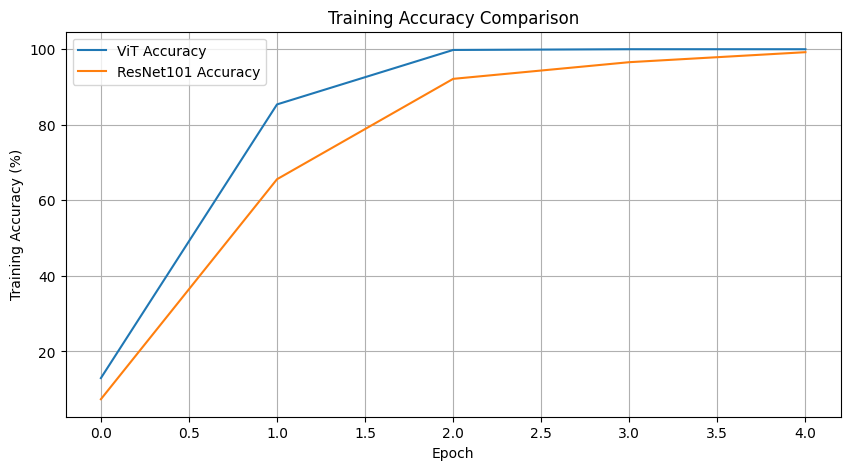

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(vit_train_acc, label='ViT Accuracy')
plt.plot(resnet_train_acc, label='ResNet101 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy (%)')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()


## 📈 Final Test Accuracy Comparison

We compare the final test accuracy of the two models using a bar chart.
This shows how well each model generalizes to unseen flower images.


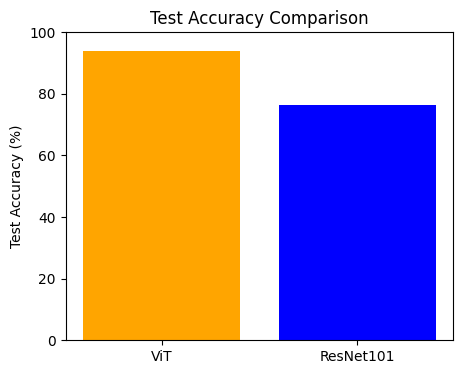

In [ ]:
vit_test_acc = 93.93
resnet_test_acc = 76.29
# Then plot:
plt.figure(figsize=(5, 4))
plt.bar(['ViT', 'ResNet101'], [vit_test_acc, resnet_test_acc], color=['orange', 'blue'])
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison')
plt.ylim(0, 100)
plt.show()
